<a href="https://colab.research.google.com/github/jeffblackadar/CRANE-CCAD-maps/blob/main/class_tile_tiff_improved_kennedy_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tile_tiff Introduction, set up

## Problem:
Some geotiffs are too large to be processed. For example, Azure Cognitive Services can process up to a 4mb tiff on the free tier or 50mb on the paid tier. The exmaple tiff is 90 mb.

## Function:
This program takes a large geotiff and divides it into smaller geotiff tiles.

## Inputs:
Georeferenced map. Get the CRS and plan what CRS will be used. 

## Outputs:



In [2]:
!pip install rasterio
!pip install geopandas

     |████████████████████████████████| 19.1MB 307kB/s 
     |████████████████████████████████| 1.0MB 15.7MB/s 
     |████████████████████████████████| 15.3MB 48.5MB/s 
     |████████████████████████████████| 6.5MB 36.7MB/s 


# Class Tile_tiff

In [3]:
import rasterio
import rasterio.plot
import gdal
import osr
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
import gdalnumeric
import cv2
import os

class Tile_tiff:

    # class attribute
    tiff_to_tile_path = "" # the source tiff to be split into tiles
    tt_tile_path = "/content/" # the path to where the tiles are saved   

    # varables for gdal    
    tt_gdal_dataset = ""
    tt_srs = ""
    tt_cols = 0
    tt_rows = 0

    # varables for rasterio
    tt_raterio_dataset = 0
    tt_crs = 0
    tt_crs_int = 0
    tt_left_min_x = 0
    tt_bottom_min_y = 0
    tt_right_max_x = 0
    tt_top_max_y = 0
    tt_coords = 0
    tt_pixel_size_x = 0
    tt_pixel_size_y = 0

    # set this for tile size
    tt_tile_pixel_width = 1024
    tt_tile_pixel_height = 768

    # set this for overlap
    tt_tile_pixel_width_overlap = 0 # 200
    tt_tile_pixel_height_overlap = 0 # 100

    tt_tile_matrix = []
    # gdal
    tt_gdal_driver = ""
    tt_gdal_dataset = ""
    tt_gdal_dataset_band = ""
    tt_gdal_transform = ""
    tt_gdal_data = ""

    def create_tile_matrix(self):
        self.tt_tile_matrix = []
        number_tiles_wide = int(self.tt_cols/(self.tt_tile_pixel_width - self.tt_tile_pixel_width_overlap))+1
        number_tiles_high = int(self.tt_rows/(self.tt_tile_pixel_height - self.tt_tile_pixel_height_overlap))+1
        print("create_tile_matrix", number_tiles_wide,number_tiles_high)    
        # rows
        for tif_rows in range(0, number_tiles_high):
            # columns
            for tif_cols in range(0, number_tiles_wide):

                lrx = 0 + ((self.tt_tile_pixel_width - self.tt_tile_pixel_width_overlap) * tif_cols)  # self.tt_left_min_x
                lry = 0 + ((self.tt_tile_pixel_height - self.tt_tile_pixel_height_overlap) * tif_rows)  # self.tt_bottom_min_y

                ulx = lrx + self.tt_tile_pixel_width
                uly = lry + self.tt_tile_pixel_height
                if(lrx>self.tt_cols):
                    lrx=self.tt_cols
                
                if(lry>self.tt_rows):
                    lry=self.tt_rows
                
                if(ulx>self.tt_cols):
                    ulx=self.tt_cols
                
                if(uly>self.tt_rows):
                    uly=self.tt_rows
                
                self.tt_tile_matrix.append([[lrx, lry], [ulx, uly], [tif_cols,tif_rows]])

        return(self.tt_tile_matrix)
    
    def create_tile_files(self):
        self.tt_boundary_polys = gpd.GeoDataFrame()
        self.tt_boundary_polys['geometry'] = None
        self.tt_boundary_polys.crs = ("EPSG:" + str(self.tt_crs_int))
        self.tt_boundary_polys.geometry = self.tt_boundary_polys.geometry.to_crs(crs=self.tt_crs_int)
        self.tt_boundary_polys.to_crs(crs=self.tt_crs_int)
        self.tt_boundary_polys = self.tt_boundary_polys.to_crs(epsg=self.tt_crs_int)
        for tile in self.tt_tile_matrix:
            minx = tile[0][0]
            maxx = tile[1][0]
            miny = tile[0][1]
            maxy = tile[1][1]

            tilex = "00"+str(tile[2][0])
            tilex = tilex[-2:]
            tiley = "00"+str(tile[2][1])
            tiley = tiley[-2:]

            self.tt_gdal_data = self.tt_gdal_dataset_band.ReadAsArray(minx, miny, maxx-minx, maxy-miny)

            output_file_name_base = "r" + tiley + "c" + tilex 
            output_file_name_tiff = output_file_name_base + ".tif"
            output_file_path = os.path.join(self.tt_tile_path,output_file_name_tiff)
            print(output_file_path)
            print(self.tt_gdal_dataset)

            self.tile_dst_ds = gdal.Translate(output_file_path, self.tt_gdal_dataset, srcWin = [minx, miny, maxx-minx, maxy-miny])
            print(self.tile_dst_ds)
            this_tile_x_min = self.tt_left_min_x + (minx*self.tt_pixel_size_x)
            this_tile_y_min = self.tt_top_max_y - (miny*self.tt_pixel_size_y)
            this_tile_x_max = self.tt_left_min_x + (maxx*self.tt_pixel_size_x)
            this_tile_y_max = self.tt_top_max_y - (maxy*self.tt_pixel_size_y)
            print("this_tile_transform",this_tile_x_min, self.tt_gdal_transform[1], self.tt_gdal_transform[2], this_tile_y_min, self.tt_gdal_transform[4], self.tt_gdal_transform[5])
            this_tile_transform = (this_tile_x_min, self.tt_gdal_transform[1], self.tt_gdal_transform[2], this_tile_y_min, self.tt_gdal_transform[4], self.tt_gdal_transform[5])
            print("this_tile_transform2",this_tile_transform)
            ## COLOR
            self.tile_dst_ds.GetRasterBand(1).SetRasterColorTable(self.tt_gdal_dataset_band.GetRasterColorTable())
            self.tile_dst_ds.GetRasterBand(1).SetRasterColorInterpretation(self.tt_gdal_dataset_band.GetRasterColorInterpretation())


            # Write metadata
            self.tile_dst_ds.SetGeoTransform(this_tile_transform)
            self.tile_dst_ds.SetProjection(self.tt_gdal_dataset.GetProjection())
            
            self.tile_dst_ds.GetRasterBand(1).WriteArray(self.tt_gdal_data)
            self.tile_dst_ds = None

            coords = [(this_tile_x_min, this_tile_y_min), (this_tile_x_max, this_tile_y_min), (this_tile_x_max, this_tile_y_max), (this_tile_x_min, this_tile_y_max)]
            poly = Polygon(coords)
            new_tp_row = {'id':output_file_name_base, 'geometry':poly}
            self.tt_boundary_polys = self.tt_boundary_polys.append(new_tp_row, ignore_index=True)     

        self.tt_boundary_polys.to_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))

    def __init__(self,tiff_to_tile_path, tt_tile_path = "/content/"):
        self.tiff_to_tile_path = tiff_to_tile_path
        self.tt_tile_path = tt_tile_path

        self.tt_raterio_dataset = rasterio.open(self.tiff_to_tile_path)
        self.tt_rows,self.tt_cols = self.tt_raterio_dataset.shape
        self.tt_crs =  self.tt_raterio_dataset.crs
        if(self.tt_crs.is_valid):
            
            self.tt_crs_int = int(str(self.tt_crs)[5:])
        else:
            self.tt_crs_int = 3857
        self.tt_srs = osr.SpatialReference()

        self.tt_srs.ImportFromEPSG(int(str(self.tt_crs_int)))

        self.tt_left_min_x = self.tt_raterio_dataset.bounds[0]
        self.tt_bottom_min_y = self.tt_raterio_dataset.bounds[1]
        self.tt_right_max_x = self.tt_raterio_dataset.bounds[2]
        self.tt_top_max_y = self.tt_raterio_dataset.bounds[3]
        self.tt_coords = [(self.tt_left_min_x, self.tt_bottom_min_y), (self.tt_right_max_x, self.tt_bottom_min_y), (self.tt_right_max_x, self.tt_top_max_y), (self.tt_left_min_x, self.tt_top_max_y)]
    
        self.tt_pixel_size_x, self.tt_pixel_size_y = self.tt_raterio_dataset.res

        self.tt_gdal_driver = gdal.GetDriverByName('GTiff')
        self.tt_gdal_dataset = gdal.Open(tiff_to_tile_path)
        self.tt_gdal_dataset_band = self.tt_gdal_dataset.GetRasterBand(1)
        self.tt_gdal_transform = self.tt_gdal_dataset.GetGeoTransform()
    
    def plot_tif_and_poly(self):
        poly_df=gpd.read_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
        rasterio.plot.show(self.tt_raterio_dataset, ax=ax)
        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

        tiles = []
        for tf in tiles:
            tif_file = rasterio.open(tf)
            rasterio.plot.show(tif_file, ax=ax)

        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
    def plot_tif_and_poly_map_overlap(self, tiles):
        poly_df=gpd.read_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
        rasterio.plot.show(self.tt_raterio_dataset, ax=ax)
        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

        for tf in tiles:
            tif_file = rasterio.open(tf)
            rasterio.plot.show(tif_file, ax=ax)

        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)

    def plot_tif_and_poly_map5_overlap(self, tiles):
        poly_df=gpd.read_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
        rasterio.plot.show(self.tt_raterio_dataset, ax=ax)
        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

        for tf in tiles:
            tif_file = rasterio.open(tf)
            rasterio.plot.show(tif_file, ax=ax)

        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        poly_df['coords'] = poly_df['geometry'].apply(lambda x: x.representative_point().coords[:])
        poly_df['coords'] = [coords[0] for coords in poly_df['coords']]

        for idx, row in poly_df.iterrows():
            ax.annotate(s=row['id'], xy=row['coords'], horizontalalignment='center')

    def plot_tif_and_poly_map_no_overlap(self, tiles):
        poly_df=gpd.read_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
        rasterio.plot.show(self.tt_raterio_dataset, ax=ax)
        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        ax = poly_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

        for tf in tiles:
            tif_file = rasterio.open(tf)
            rasterio.plot.show(tif_file, ax=ax)

        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        poly_df['coords'] = poly_df['geometry'].apply(lambda x: x.representative_point().coords[:])
        poly_df['coords'] = [coords[0] for coords in poly_df['coords']]

        for idx, row in poly_df.iterrows():
            plt.annotate(s=row['id'], xy=row['coords'], horizontalalignment='center')

    def get_attributes(self):
        return {
            "cols": str(self.tt_cols), 
            "rows": str(self.tt_rows),
            "crs": str(self.tt_crs),
            "left_min_x": str(self.tt_left_min_x),
            "bottom_min_y": str(self.tt_bottom_min_y),
            "right_max_x": str(self.tt_right_max_x),
            "top_max_y": str(self.tt_top_max_y),
            "coords": str(self.tt_coords),
            "pixel_size_x": str(self.tt_pixel_size_x),
            "pixel_size_y": str(self.tt_pixel_size_y)
            }


# Instantiate class

In [4]:
#tt = Tile_tiff('/content/drive/MyDrive/crane_maps_syria/maps_large/Aafrine_georef/Aafrine_georef.tif',
#               '/content/drive/MyDrive/crane_maps_syria/maps_large/Aafrine_georef/tif_tiles')
#tt = Tile_tiff('/content/drive/MyDrive/crane_maps_syria/maps_large/Djeble_georef/Djeble_georef_32637.tif',
#               '/content/drive/MyDrive/crane_maps_syria/maps_large/Djeble_georef/tif_tiles')
tt = Tile_tiff('/content/drive/MyDrive/crane_kennedy_1856/map/Kennedy 1856 Chester_modified.tif',
               '/content/drive/MyDrive/crane_kennedy_1856/tif_tiles')
tt.tt_tile_pixel_width_overlap = 300
tt.tt_tile_pixel_height_overlap = 150
print(tt.get_attributes())
print(tt.create_tile_matrix())
tt.create_tile_files()


{'cols': '14829', 'rows': '12818', 'crs': 'EPSG:3857', 'left_min_x': '-8485582.235349359', 'bottom_min_y': '4818382.138392414', 'right_max_x': '-8380859.788758856', 'top_max_y': '4908902.89639343', 'coords': '[(-8485582.235349359, 4818382.138392414), (-8380859.788758856, 4818382.138392414), (-8380859.788758856, 4908902.89639343), (-8485582.235349359, 4908902.89639343)]', 'pixel_size_x': '7.062003276721497', 'pixel_size_y': '7.062003276721497'}
create_tile_matrix 21 21
[[[0, 0], [1024, 768], [0, 0]], [[724, 0], [1748, 768], [1, 0]], [[1448, 0], [2472, 768], [2, 0]], [[2172, 0], [3196, 768], [3, 0]], [[2896, 0], [3920, 768], [4, 0]], [[3620, 0], [4644, 768], [5, 0]], [[4344, 0], [5368, 768], [6, 0]], [[5068, 0], [6092, 768], [7, 0]], [[5792, 0], [6816, 768], [8, 0]], [[6516, 0], [7540, 768], [9, 0]], [[7240, 0], [8264, 768], [10, 0]], [[7964, 0], [8988, 768], [11, 0]], [[8688, 0], [9712, 768], [12, 0]], [[9412, 0], [10436, 768], [13, 0]], [[10136, 0], [11160, 768], [14, 0]], [[10860, 0],

# Choose which tiles to transcribe based on row and column.

We don't need to waste time and mony transcribing irrelevant tiles

In [9]:
directory = r'/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/'

import os

for filename in os.listdir(directory):
    if filename.endswith(".tif"):
#rows
        if(int(filename[1:3])<1 or int(filename[1:3])>19
        or ((int(filename[1:3])==1) and ((int(filename[4:6])<9) or (int(filename[4:6])>14)))
        or ((int(filename[1:3])==2) and ((int(filename[4:6])<9) or (int(filename[4:6])>14)))
        or ((int(filename[1:3])==3) and ((int(filename[4:6])<8) or (int(filename[4:6])>15)))
        or ((int(filename[1:3])==4) and ((int(filename[4:6])<7) or (int(filename[4:6])>15)))
        or ((int(filename[1:3])==5) and ((int(filename[4:6])<6) or (int(filename[4:6])>16)))
        or ((int(filename[1:3])==6) and ((int(filename[4:6])<6) or (int(filename[4:6])>17)))
        or ((int(filename[1:3])==7) and ((int(filename[4:6])<6) or (int(filename[4:6])>18)))
        or ((int(filename[1:3])==8) and ((int(filename[4:6])<6) or (int(filename[4:6])>18)))
        or ((int(filename[1:3])==9) and ((int(filename[4:6])<5) or (int(filename[4:6])>18)))
        or ((int(filename[1:3])==10) and ((int(filename[4:6])<5) or (int(filename[4:6])>18)))
        or ((int(filename[1:3])==11) and ((int(filename[4:6])<4) or (int(filename[4:6])>17)))
        or ((int(filename[1:3])==12) and ((int(filename[4:6])<4) or (int(filename[4:6])>16)))
        or ((int(filename[1:3])==13) and ((int(filename[4:6])<4) or (int(filename[4:6])>15)))
        or ((int(filename[1:3])==14) and ((int(filename[4:6])<4) or (int(filename[4:6])>14)))
        or ((int(filename[1:3])==15) and ((int(filename[4:6])<4) or (int(filename[4:6])>14)))
        or ((int(filename[1:3])==16) and ((int(filename[4:6])<3) or (int(filename[4:6])>13)))
        or ((int(filename[1:3])==17) and ((int(filename[4:6])<2) or (int(filename[4:6])>13)))
        or ((int(filename[1:3])==18) and ((int(filename[4:6])<2) or (int(filename[4:6])>13)))
        or ((int(filename[1:3])==19) and ((int(filename[4:6])<2) or (int(filename[4:6])>13)))
        or ((int(filename[1:3])==20) and ((int(filename[4:6])<2) or (int(filename[4:6])>13)))
        ):
            pass
            #print("        #tiles.append('"+os.path.join(directory, filename)+"')")  
        else:
            print("        tiles.append('"+os.path.join(directory, filename)+"')")
            
            


        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r02c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r02c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r02c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r02c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r02c13.tif')
        tiles.append('/content/drive/MyDriv

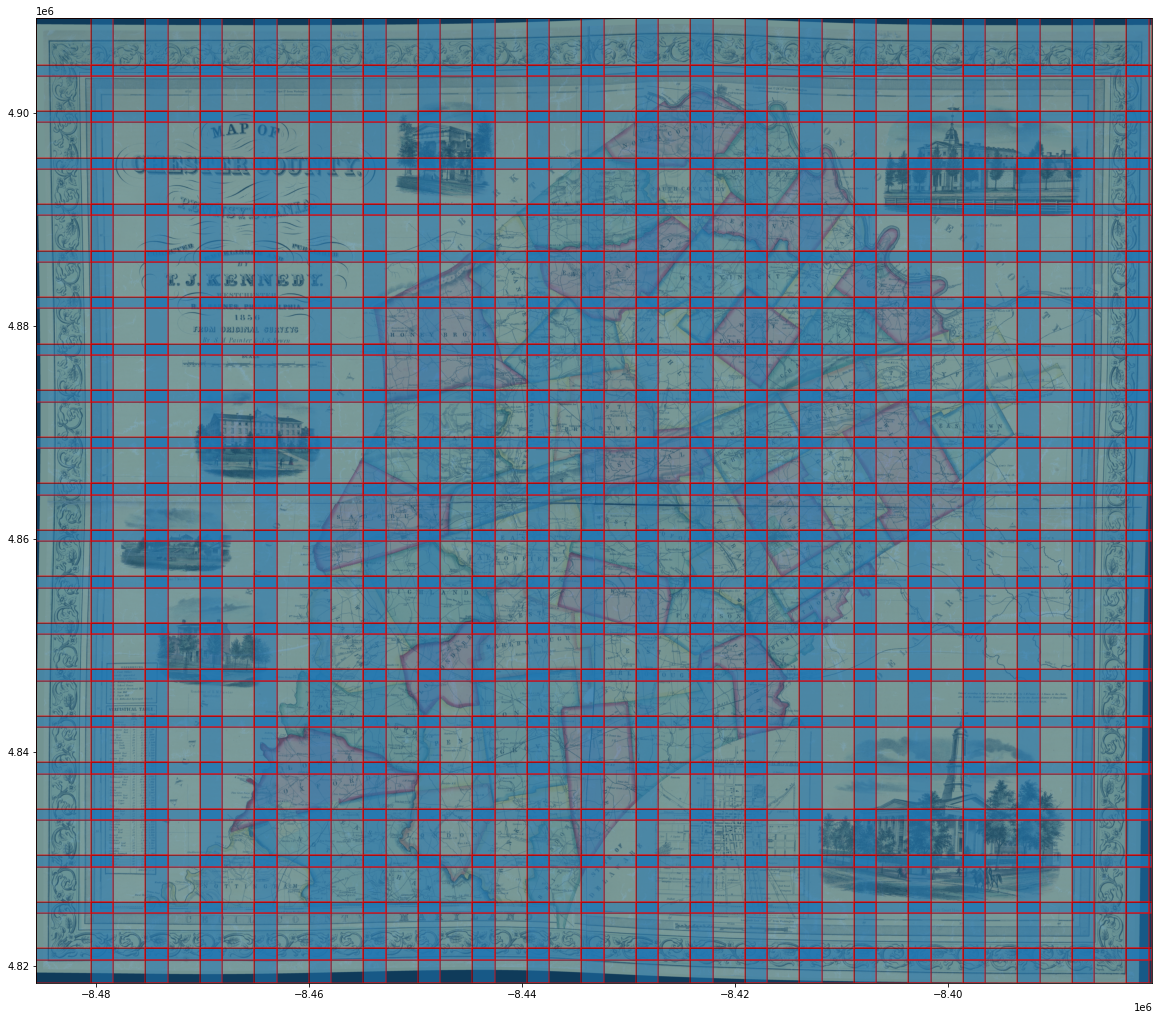

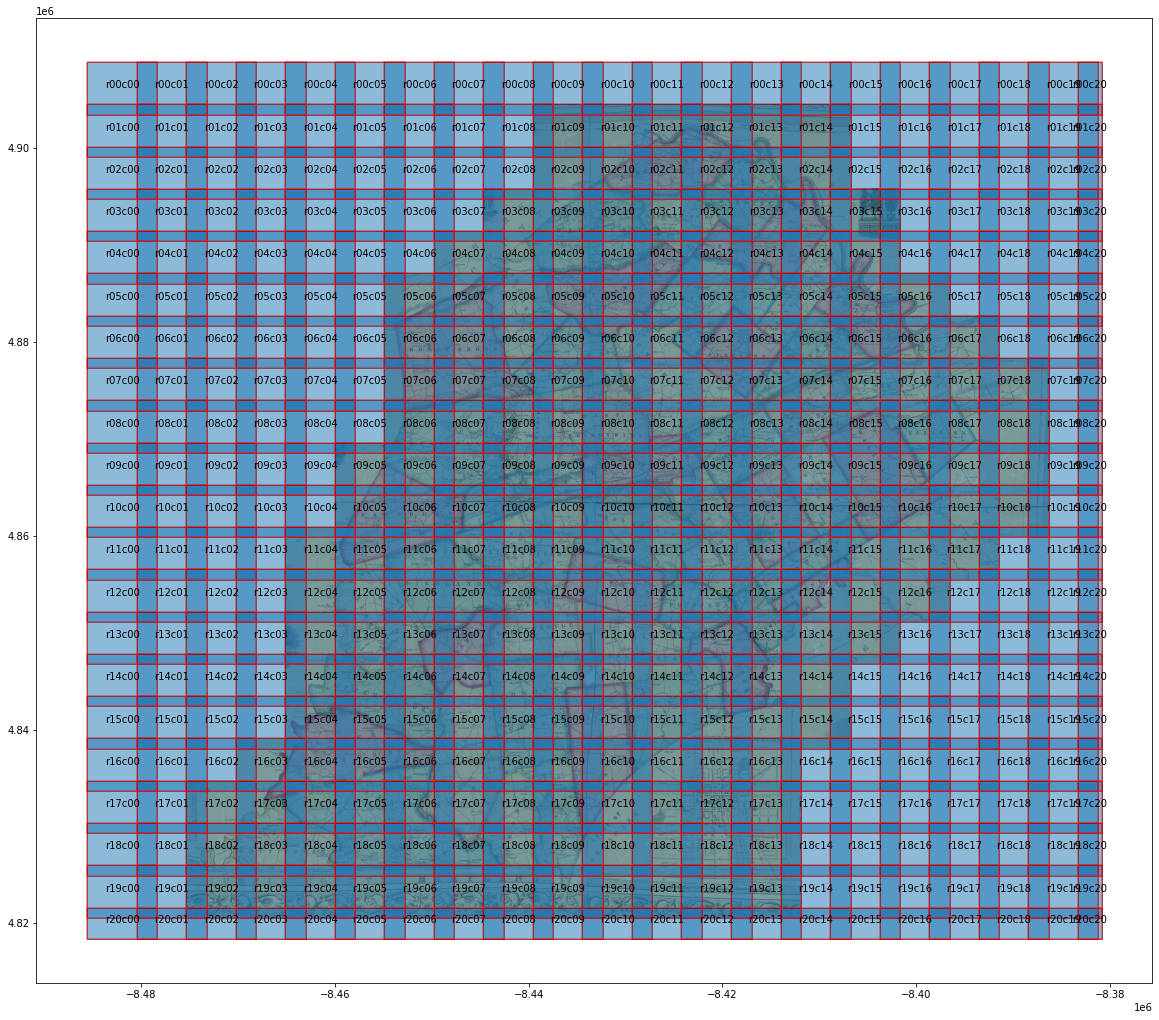

In [10]:
        tiles = []
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r01c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r02c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r02c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r02c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r02c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r02c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r02c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r03c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r03c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r03c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r03c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r03c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r03c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r03c15.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r03c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r04c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r04c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r04c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r04c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r04c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r04c15.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r04c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r04c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r04c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r05c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r05c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r05c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r05c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r05c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r05c16.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r05c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r05c15.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r05c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r05c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r05c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c16.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c15.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r06c17.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c15.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c17.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c16.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r07c18.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c15.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c17.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c16.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r08c18.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c05.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c15.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c16.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c18.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r09c17.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c05.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c15.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c17.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c16.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r10c18.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c04.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c05.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c16.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c17.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c15.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r11c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c04.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c05.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c16.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r12c15.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c04.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c05.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r13c15.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r14c05.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r14c04.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r14c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r14c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r14c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r14c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r14c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r14c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r14c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r14c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r14c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r15c04.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r15c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r15c05.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r15c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r15c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r15c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r15c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r15c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r15c14.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r15c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r15c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r16c03.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r16c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r16c05.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r16c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r16c04.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r16c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r16c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r16c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r16c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r16c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r16c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c02.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c03.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c04.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c05.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r17c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c02.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c03.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c04.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c05.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c13.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r18c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c03.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c02.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c05.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c04.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c06.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c08.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c07.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c11.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c09.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c12.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c10.tif')
        tiles.append('/content/drive/MyDrive/crane_kennedy_1856/tif_tiles/r19c13.tif')
        tt.plot_tif_and_poly_map5_overlap(tiles)